# Import Libraries

Numpy, Matplotlib, MNE


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.filter import notch_filter
%matplotlib qt


# Load Data

Paths to each absence data file is stored in absence_files.txt. An EDF data file will be loaded using the MNE library as an MNE raw object.


In [20]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"

# Set absence file names
ABSENCE_FILES_NAMES = []
with open(r"processed_data\absence\absence_files.txt", "r") as f:
    for i in f.readlines():
        ABSENCE_FILES_NAMES.append(DEV_DATA_FOLDER + i[:-1])

In [21]:
# Change index to change which absence seizure to load
def loadData(seizure_idx):
    raw_edf = mne.io.read_raw_edf(ABSENCE_FILES_NAMES[seizure_idx])
    return raw_edf

In [22]:
raw_edf = loadData(0)
raw_edf.load_data()

Extracting EDF parameters from E:\edf\dev\02_tcp_le\033\00003306\s001_2006_10_11\00003306_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...


Measurement date,"October 11, 2006 14:54:02 GMT"
Experimenter,Unknown
Participant,00003306
Digitized points,Not available
Good channels,41 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


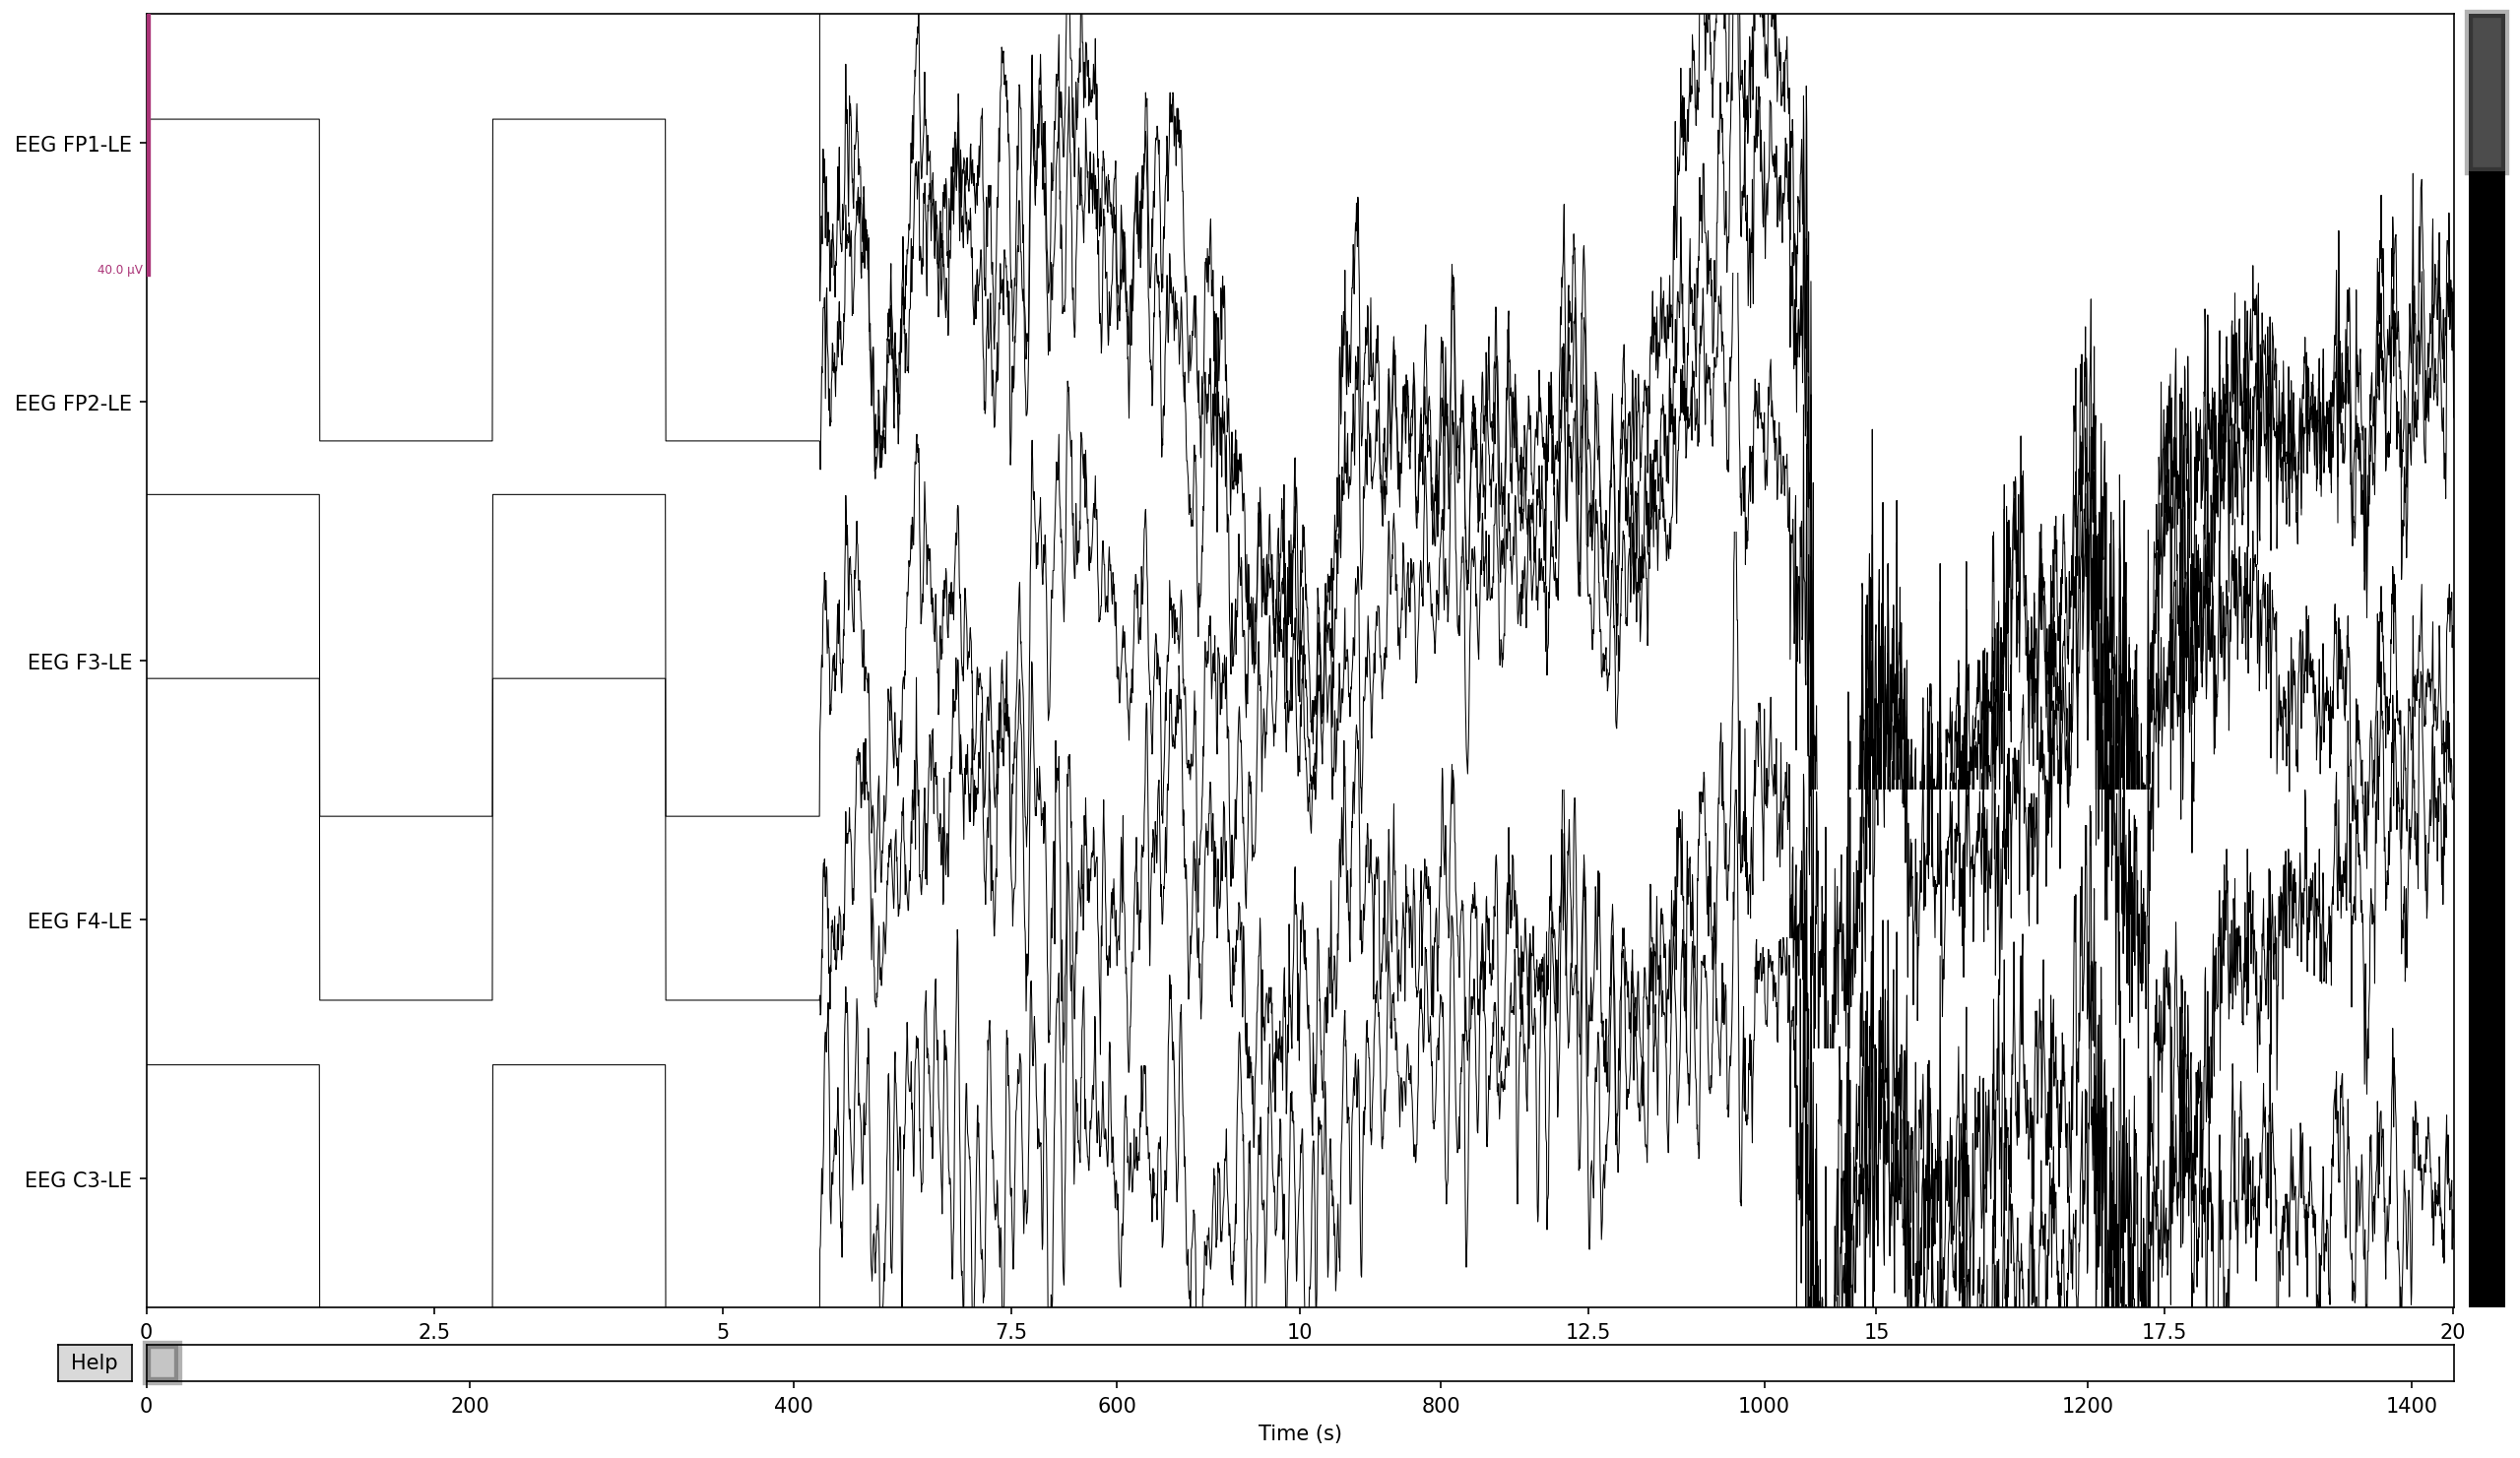

In [23]:
#Plot Data
%matplotlib qt
raw_edf.plot(duration=20, n_channels=5)


# Analyse


In [24]:
def plotFrquency(raw_edf):
    data, times = raw_edf.get_data(return_times=True)
    fft = np.fft.fft(data, axis=1)
    P2 = np.abs(fft / data.shape[1])
    P1 = P2[:, : data.shape[1] // 2]
    P1[:, 1:-1] = 2 * P1[:, 1:-1]
    f = np.linspace(0, 1 / (2 * times[1]), data.shape[1] // 2)
    plt.figure()
    plt.plot(f, P1[0, :])
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_1888\3441860465.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)


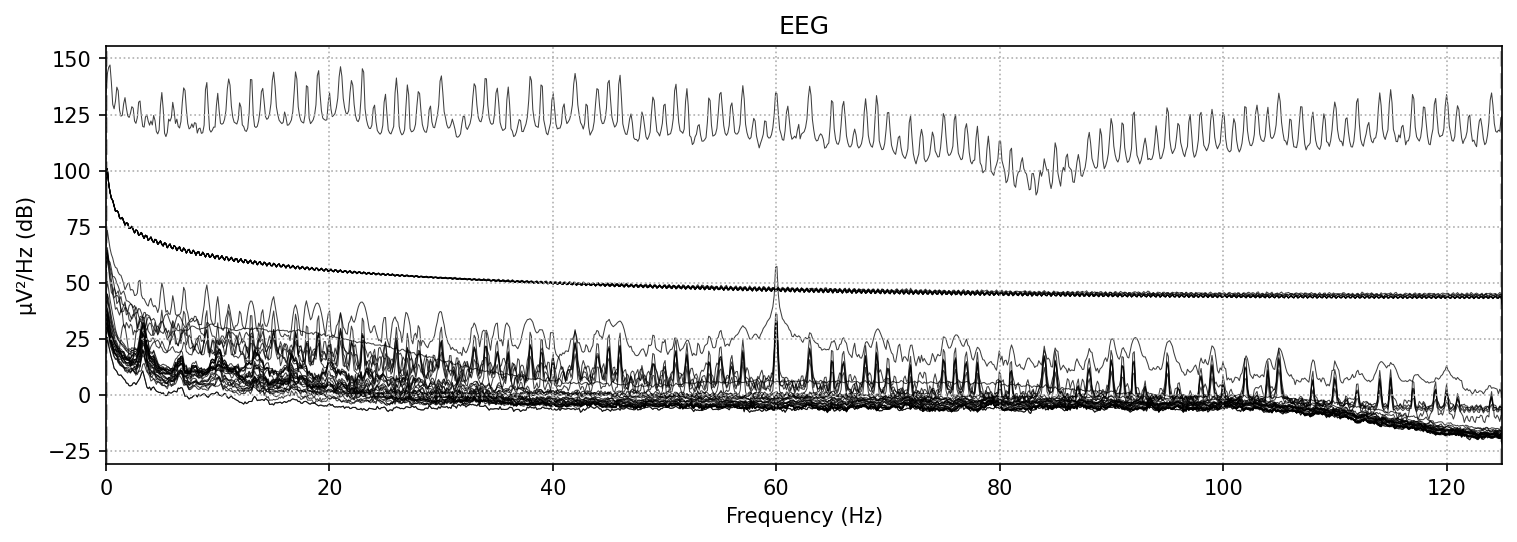

In [25]:
plotFrquency(raw_edf)
raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)

# Preprocessing

```python
notch_filter(freqs, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=None, method='fir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', skip_by_annotation=('edge', 'bad_acq_skip'), verbose=None)
```


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_1888\3527248985.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)


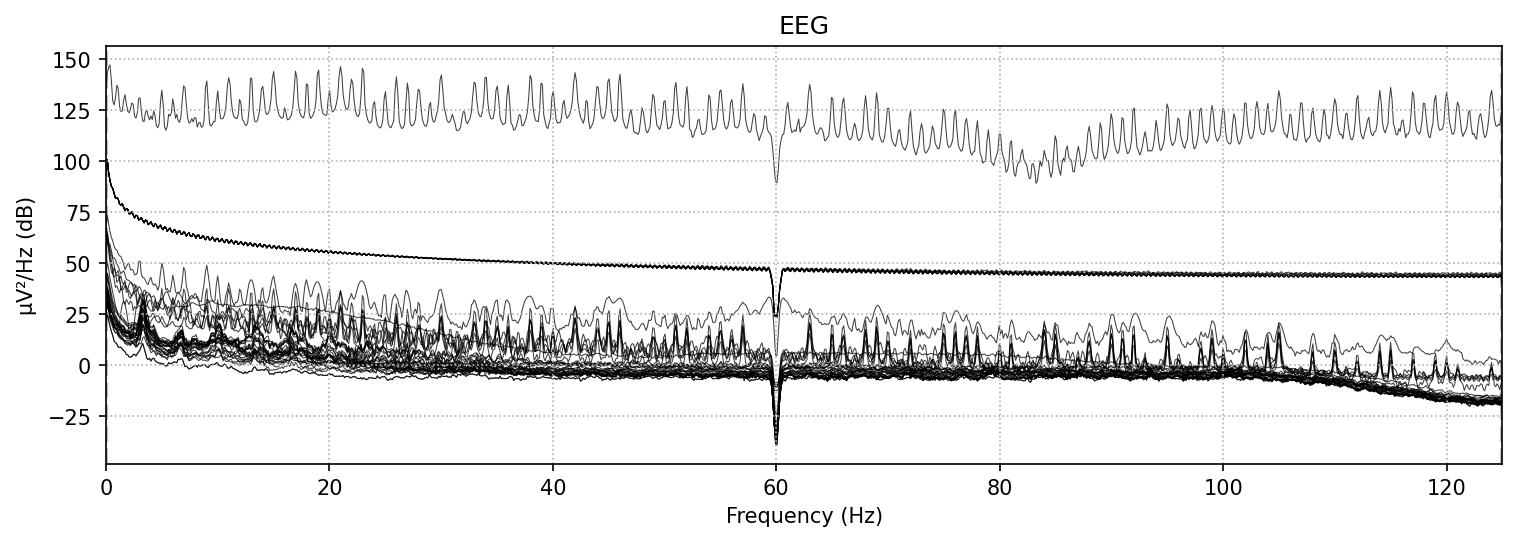

In [26]:
raw_edf.notch_filter(60)
raw_edf.compute_psd(fmax=125).plot(picks="data", exclude="bads", amplitude=False)

In [27]:
raw_edf.plot(duration=20, n_channels=5)
plotFrquency(raw_edf)

# Split into Epochs


In [161]:
epoch_duration = 4
epoch_overlap = 2
epochs = mne.make_fixed_length_epochs(
    raw_edf, duration=epoch_duration, overlap=epoch_overlap
)


# epochs.plot(n_epochs=20, n_channels=5)
epochs_vector = epochs.get_data()

Not setting metadata
712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 712 events and 1000 original time points ...
0 bad epochs dropped


In [162]:
epochs_vector.shape

(712, 41, 1000)

# Create Labels


In [45]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [54]:
annotations = format_annotations(
    annotations_file=r"processed_data\absence\annotations\00003306_s001_t001\00003306_s001_t001.tse"
)
print(annotations)

[['0.0000', '193.8440', 'bckg'], ['193.8440', '200.0440', 'absz'], ['200.0440', '287.8320', 'bckg'], ['287.8320', '296.5320', 'absz'], ['296.5320', '564.3040', 'bckg'], ['564.3040', '573.2149', 'absz'], ['573.2149', '1355.6120', 'bckg'], ['1355.6120', '1363.3120', 'absz'], ['1363.3120', '1426.0000', 'bckg']]


In [164]:
# 0 = no seizure, 1 = absence seizure
def create_labels(raw_edf, annotations):
    data, time = raw_edf.get_data(return_times=True)
    duration_seconds = time[-1]

    events = {}
    for i in range(int(len(time) / 250)):
        for j in annotations:
            if i in range(int(float(j[0])), int(float(j[1]))):
                if j[2] == "bckg":
                    events[i * 250] = 0
                elif j[2] == "absz":
                    events[i * 250] = 1

    return events

In [165]:
events = create_labels(raw_edf, annotations)

In [177]:
from sympy import I


def scale_labels_to_epochs(epochs, events):
    epoch_labels = [None] * len(epochs.get_data())

    for i in range(0, len(epochs.get_data()), 2):
        epoch_labels[i] = events[i * 250]

    for i, v in enumerate(epoch_labels):  
        if v == None:
            if i != len(epoch_labels) - 1: 
                if epoch_labels[i - 1] == 0 and epoch_labels[i + 1] == 0:
                        epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1 and epoch_labels[i + 1] == 1:
                    epoch_labels[i] = 1
                else:
                    epoch_labels[i] = 0.5
            else:
                if epoch_labels[i - 1] == 0:
                    epoch_labels[i] = 0
                elif epoch_labels[i - 1] == 1:
                    epoch_labels[i] = 1

    return epoch_labels

In [179]:
labels = scale_labels_to_epochs(epochs, events)
print(labels)

Using data from preloaded Raw for 712 events and 1000 original time points ...
Using data from preloaded Raw for 712 events and 1000 original time points ...
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 1, 1, 1, 1, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 